In [1]:
## Initialize

from scipy.optimize import curve_fit
import numpy as np; from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd; import sys
from scipy.signal import argrelmax
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
import timeit

label_size = 15
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

def multigauss(x, *params): #define multiple gauss function
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def peakdet(v, delta, x = None): #peak finding algorithm from https://gist.github.com/endolith/250860
    maxtab = []
    mintab = []
    if x is None:
        x = arange(len(v))
    v = asarray(v) 
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')  
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')   
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN   
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]       
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True              
    return array(maxtab), array(mintab)

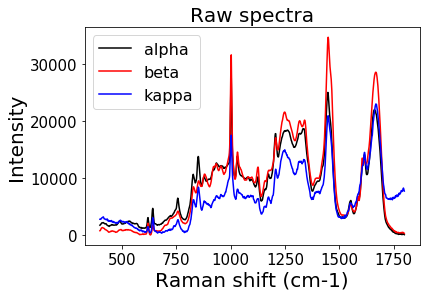

In [2]:
## Load data
data = pd.read_csv('a b k bulk spectra.txt', delimiter="\t")
x = np.array(data['shiftb']) #define x-axis (Raman shift variable)
a = np.array(data['a'])
b = np.array(data['b'])
k = np.array(data['k'])
rawspec = np.stack([a, b, k],axis=0) #matrix of all spectra intensities

filteredspecraw = np.empty((3,len(a)))
for i in range(3): #get one matrix with all filtered spectra
    filteredspecraw[i] = savgol_filter(rawspec[i], 5, 2, mode='mirror')
    
# Plot all spectra
plt.plot(x,filteredspecraw[0], color='k', label='alpha')
plt.plot(x,filteredspecraw[1], color='r', label='beta')
plt.plot(x,filteredspecraw[2], color='b', label='kappa')
plt.legend(fontsize=16); plt.title('Raw spectra',fontsize=20, ha='center');
plt.ylabel('Intensity', fontsize=20); plt.xlabel('Raman shift (cm-1)', fontsize=20); plt.show()

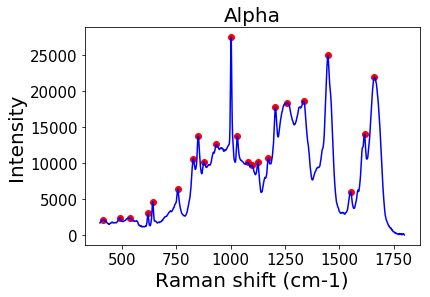

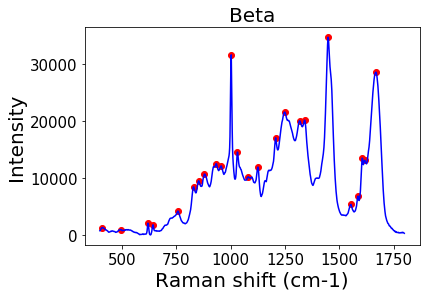

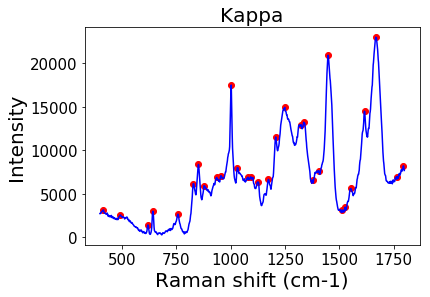

peak-finding time = 0.6009051469577432 seconds


In [3]:
#Find peaks in spectra - NO BASELINE SUBTRACTION

data = pd.read_csv('a b k bulk spectra.txt', delimiter="\t")
x = np.array(data['shiftb']) #define x-axis (Raman shift variable)
a = np.array(data['a'])
b = np.array(data['b'])
k = np.array(data['k'])
rawspec = np.stack([a, b, k],axis=0) #matrix of all spectra intensities

filteredspec = np.empty((3,len(a)))
for i in range(3): #get one matrix with all filtered spectra
    filteredspec[i] = savgol_filter(rawspec[i], 5, 2, mode='mirror')
    
#######################################
minpeakheight = 250 #set a minimum peak height to search for
#######################################

start_peak_time = timeit.default_timer()

#get peaks for each spectrum
maxtab, mintab = peakdet(filteredspec[0],minpeakheight,x) 
apeaks = np.copy(maxtab); apeaksx = array(apeaks)[:,0]; apeaksy = array(apeaks)[:,1]
maxtab, mintab = peakdet(filteredspec[1],minpeakheight,x)
bpeaks = np.copy(maxtab); bpeaksx = array(bpeaks)[:,0]; bpeaksy = array(bpeaks)[:,1]
maxtab, mintab = peakdet(filteredspec[2],minpeakheight,x)
kpeaks = np.copy(maxtab); kpeaksx = array(kpeaks)[:,0]; kpeaksy = array(kpeaks)[:,1]

plt.scatter(array(apeaks)[:,0], array(apeaks)[:,1], color='r') #plot peak maximums
plt.plot(x,filteredspec[0], color='b')
plt.title('Alpha',fontsize=20, ha='center'); plt.ylabel('Intensity', fontsize=20)
plt.xlabel('Raman shift (cm-1)', fontsize=20); plt.show()

plt.scatter(array(bpeaks)[:,0], array(bpeaks)[:,1], color='r') #plot peak maximums
plt.plot(x,filteredspec[1], color='b')
plt.title('Beta',fontsize=20, ha='center'); plt.ylabel('Intensity', fontsize=20)
plt.xlabel('Raman shift (cm-1)', fontsize=20); plt.show()

plt.scatter(array(kpeaks)[:,0], array(kpeaks)[:,1], color='r') #plot peak maximums
plt.plot(x,filteredspec[2], color='b')
plt.title('Kappa',fontsize=20, ha='center'); plt.ylabel('Intensity', fontsize=20)
plt.xlabel('Raman shift (cm-1)', fontsize=20); plt.show()

print('peak-finding time = ' + format(timeit.default_timer() - start_peak_time) + ' seconds')

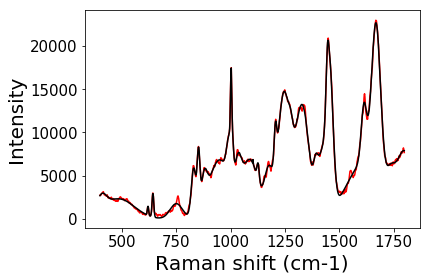

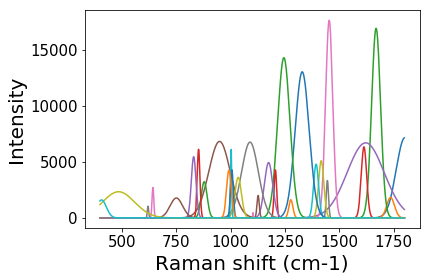

Number of peaks = 30
fitting time =0.3588062520111604 minutes


In [4]:
## Fit peaks in each spectra

start_fit_time = timeit.default_timer()

#guess peak centers, amplitudes, widths
guess = np.ones(len(kpeaksx)*3)
for i in range(0,len(guess),3):
    guess[i] = kpeaksx[round(i/3)]
    guess[i+1] = kpeaksy[round((i-1)/3)]
    guess[i+2] = 5   

hibound = 100000 #set fitting bounds
lobound = 0

popt, pcov = curve_fit(multigauss, x, filteredspec[2], ftol=5e-6, xtol=1e-7, p0=guess, bounds=(lobound,hibound)) # find fit parameters
fit = multigauss(x, *popt) #build fit from parameters

############################# save fit parameters
centers = np.array([]); amplitudes = np.array([]); widths = np.array([])
for i in range(0,len(popt),3): # build lists of fitting parameters
    centers = np.append(centers, popt[i])
    amplitudes = np.append(amplitudes, popt[i+1])
    widths = np.append(widths, popt[i+2])

plt.plot(x, filteredspec[2], 'r-') #plot spectrum and its fit
plt.plot(x, fit , 'k-'); plt.xlabel('Raman shift (cm-1)', fontsize=20); plt.ylabel('Intensity', fontsize=20) 
plt.show()
     
for i in range(len(centers)): #plot deconvoluted peaks
    y = amplitudes[i] * np.exp( -((x - centers[i])/widths[i])**2)
    plt.plot(x,y)
plt.xlabel('Raman shift (cm-1)', fontsize=20); plt.ylabel('Intensity', fontsize=20); plt.show()

print('Number of peaks = ' + format(len(centers)))

print('fitting time =' + format((timeit.default_timer() - start_fit_time)/60) + ' minutes')

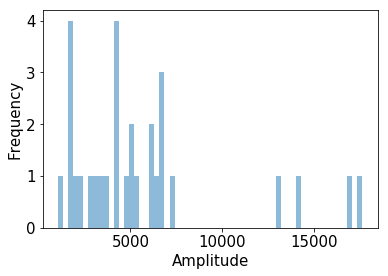

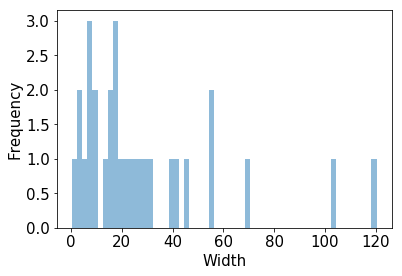

In [5]:
plt.hist(amplitudes, bins=60, alpha=0.5)
plt.xlabel('Amplitude', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

plt.hist(widths, bins=60, alpha=0.5)
plt.xlabel('Width', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()